In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adamax, Nadam, Adagrad, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

import logging
logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

2024-05-26 20:07:17.702199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 20:07:17.702298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 20:07:17.831701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the dataset

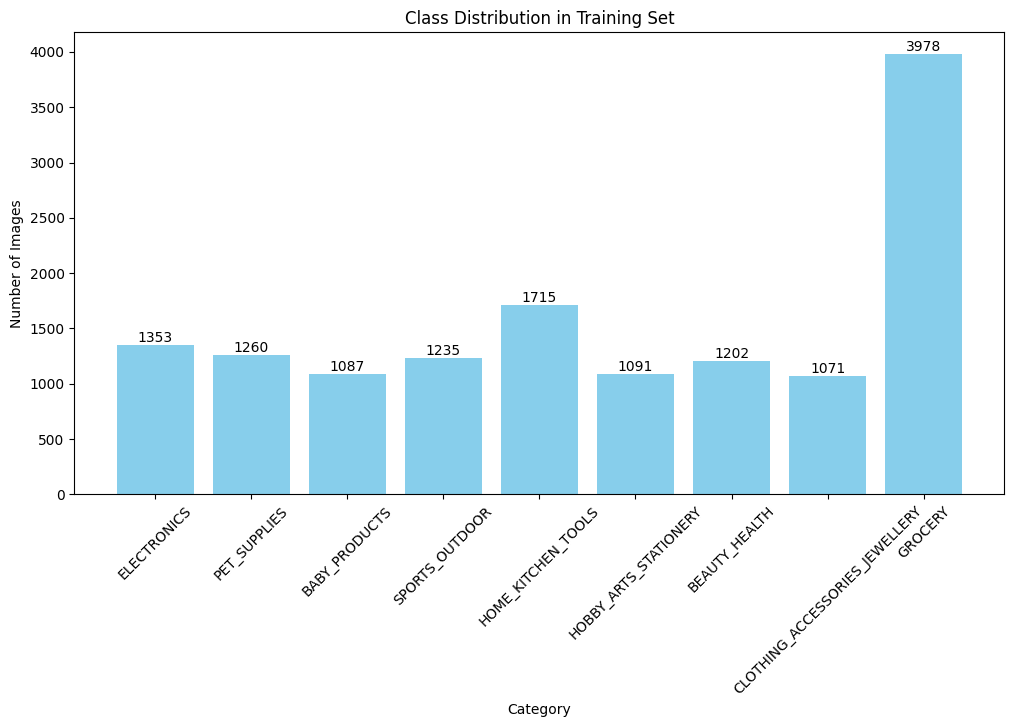

In [4]:
base_dir = '/kaggle/input/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
check_dir = os.path.join(base_dir, 'check')

# Get category names
categories = os.listdir(train_dir)

# Count images in each category
def count_images(directory):
    counts = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        counts[category] = len(os.listdir(category_path))
    return counts

train_counts = count_images(train_dir)

# Plot class distribution with labels
plt.figure(figsize=(12, 6))
bars = plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.show()

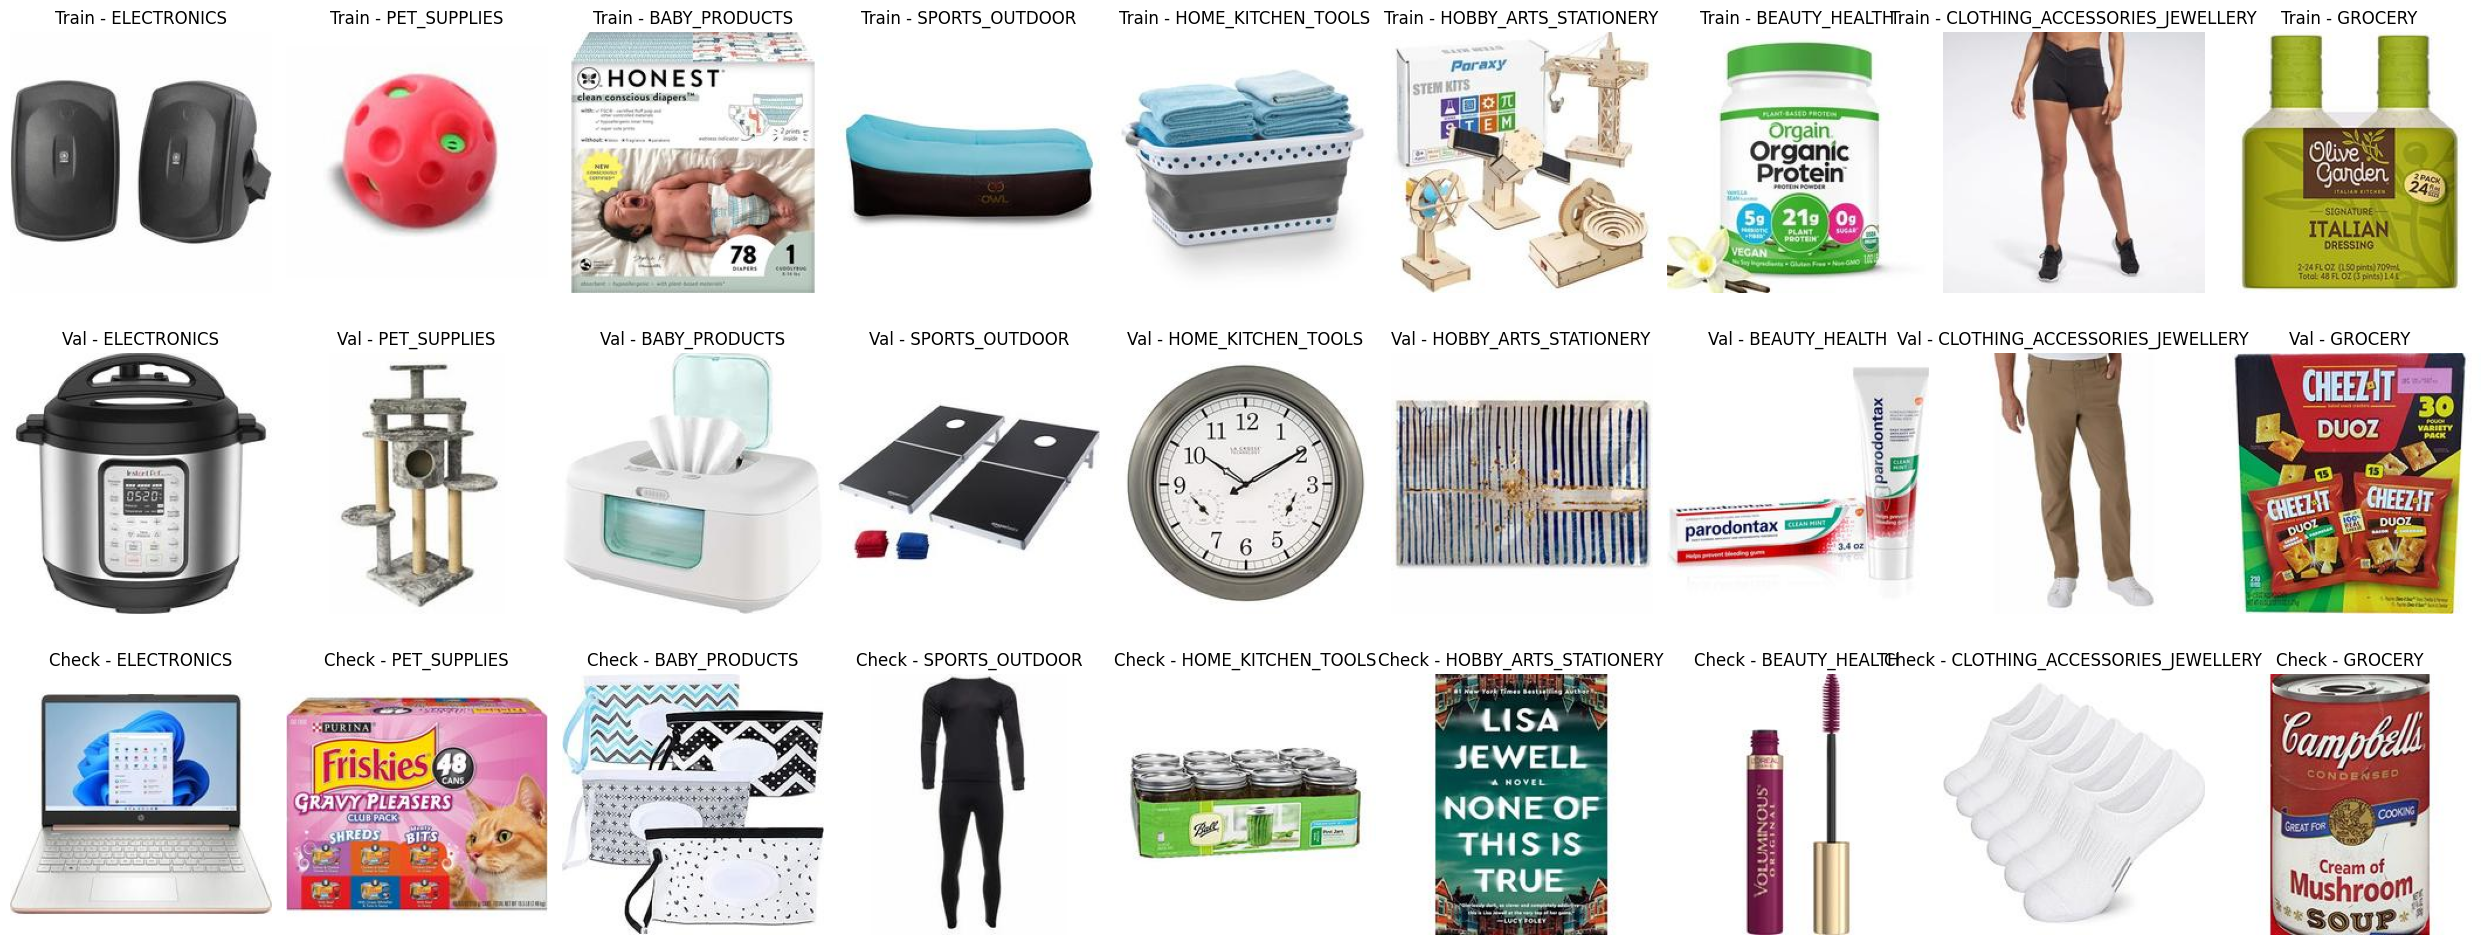

In [5]:
# Function to load a single sample image from each category
def load_sample_images(base_dir, categories):
    sample_images = []
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        images = [img for img in os.listdir(category_dir) if img.lower().endswith(('.jpg', '.jpeg'))]
        if images:
            img_name = random.choice(images)
            img_path = os.path.join(category_dir, img_name)
            sample_images.append((img_path, category))
    return sample_images

# Get categories
categories = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Load sample images
train_samples = load_sample_images(train_dir, categories)
val_samples = load_sample_images(val_dir, categories)
check_samples = load_sample_images(check_dir, categories)

# Plotting
fig, axes = plt.subplots(3, 9, figsize=(25, 10))

for i, (img_path, category) in enumerate(train_samples):
    img = load_img(img_path)
    ax = axes[0, i]
    ax.imshow(img)
    ax.set_title(f"Train - {category}")
    ax.axis('off')

for i, (img_path, category) in enumerate(val_samples):
    img = load_img(img_path)
    ax = axes[1, i]
    ax.imshow(img)
    ax.set_title(f"Val - {category}")
    ax.axis('off')

for i, (img_path, category) in enumerate(check_samples):
    img = load_img(img_path)
    ax = axes[2, i]
    ax.imshow(img)
    ax.set_title(f"Check - {category}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation techniques
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range = 0.2
)

# Example of using the generator
train_generator = datagen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

Found 13992 images belonging to 9 classes.


In [7]:
# Get category labels from the generator
labels = train_generator.class_indices

# Print labels
print("Category Labels:")
for category, label in labels.items():
    print(f"{category}: {label}")

Category Labels:
BABY_PRODUCTS: 0
BEAUTY_HEALTH: 1
CLOTHING_ACCESSORIES_JEWELLERY: 2
ELECTRONICS: 3
GROCERY: 4
HOBBY_ARTS_STATIONERY: 5
HOME_KITCHEN_TOOLS: 6
PET_SUPPLIES: 7
SPORTS_OUTDOOR: 8


In [8]:
# Define validation data generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

# Example of using the generator for the validation set
val_generator = val_datagen.flow_from_directory(
    val_dir,
    color_mode = 'rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle= False
)

Found 3632 images belonging to 9 classes.


# Compile The Models

In [9]:
# Parameters
img_size = (224, 224)
batch_size = 32
num_classes = 9
epochs = 25

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

In [10]:
# Define different optimizers
optimizers = {
    'SGD': SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
    'RMSprop': RMSprop(learning_rate=1e-4),
    'Adam': Adam(learning_rate=1e-4),
    'AdamW': tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    'Adagrad': Adagrad(learning_rate=1e-4),
    'Adadelta': Adadelta(learning_rate=1e-4),
    'Adamax': tf.keras.optimizers.Adamax(learning_rate=1e-4),
    'Nadam': tf.keras.optimizers.Nadam(learning_rate=1e-4)
}

In [17]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

# Add out top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base layer and our top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Choose the optimizer from optimizers dictionary
optimizer_ = optimizers['Adam']

# Compile the model
model.compile(optimizer=optimizer_, loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compiled and ready for training.")

Model compiled and ready for training.


In [18]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks
)

print("Training complete.")

Epoch 1/25
  1/438 ━━━━━━━━━━━━━━━━━━━━ 2:32:25 21s/step - accuracy: 0.1250 - loss: 3.1297

I0000 00:00:1716754872.299965     241 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/438 ━━━━━━━━━━━━━━━━━━━━ 2:10 472ms/step - accuracy: 0.4333 - loss: 1.9540

W0000 00:00:1716754947.773060     239 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 234s 488ms/step - accuracy: 0.5045 - loss: 1.6662 - val_accuracy: 0.7274 - val_loss: 0.8782 - learning_rate: 1.0000e-04
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 171s 385ms/step - accuracy: 0.6765 - loss: 1.0140 - val_accuracy: 0.7574 - val_loss: 0.7873 - learning_rate: 1.0000e-04
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 170s 382ms/step - accuracy: 0.7288 - loss: 0.8175 - val_accuracy: 0.7720 - val_loss: 0.7338 - learning_rate: 1.0000e-04
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 171s 384ms/step - accuracy: 0.7636 - loss: 0.7356 - val_accuracy: 0.7822 - val_loss: 0.7115 - learning_rate: 1.0000e-04
Epoch 5/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 168s 378ms/step - accuracy: 0.7914 - loss: 0.6432 - val_accuracy: 0.7825 - val_loss: 0.7278 - learning_rate: 1.0000e-04
Epoch 6/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 168s 378ms/step - accuracy: 0.8039 - loss: 0.5886 - val_accuracy: 0.7877 - val_loss: 0.7164 - learning_rate: 1.0000e-04
Epoch 7/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 168s 377ms/

In [39]:
# # Save the entire model to a file
# model.save('mobilenetv2_18K_model2.h5')

# print("Model saved to mobilenetv2_18K_model2.h5")


Model saved to mobilenetv2_18K_model2.h5


In [40]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('mobilenetv2_18K_model2.h5')

print("Model loaded from mobilenetv2_18K_model2.h5")

Model loaded from mobilenetv2_18K_model2.h5


114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step


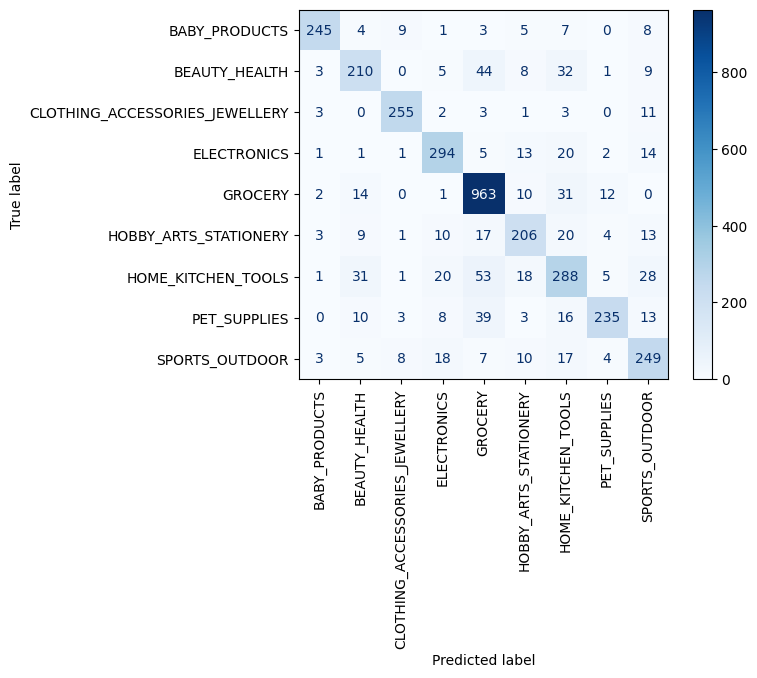

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Get the true labels
true_labels = val_generator.classes

# Make predictions
predictions = model.predict(val_generator, steps=len(val_generator), verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [42]:
# Print classification report
report = classification_report(true_labels, predicted_classes, target_names=labels)
print(report)

                                precision    recall  f1-score   support

                 BABY_PRODUCTS       0.94      0.87      0.90       282
                 BEAUTY_HEALTH       0.74      0.67      0.70       312
CLOTHING_ACCESSORIES_JEWELLERY       0.92      0.92      0.92       278
                   ELECTRONICS       0.82      0.84      0.83       351
                       GROCERY       0.85      0.93      0.89      1033
         HOBBY_ARTS_STATIONERY       0.75      0.73      0.74       283
            HOME_KITCHEN_TOOLS       0.66      0.65      0.66       445
                  PET_SUPPLIES       0.89      0.72      0.80       327
                SPORTS_OUTDOOR       0.72      0.78      0.75       321

                      accuracy                           0.81      3632
                     macro avg       0.81      0.79      0.80      3632
                  weighted avg       0.81      0.81      0.81      3632



# Deployment

In [43]:
# Function to randomly select an image from the 'check' directory
def get_random_image(sample_dataset_dir):
    classes = os.listdir(sample_dataset_dir)
    selected_class = random.choice(classes)
    class_dir = os.path.join(sample_dataset_dir, selected_class)
    image_name = random.choice(os.listdir(class_dir))
    image_path = os.path.join(class_dir, image_name)
    return image_path, selected_class

# Function to preprocess the image
def preprocess_image(img_path):
    # Load the image (this itself is a printable image)
    loaded_img = image.load_img(img_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img = image.img_to_array(loaded_img)
    # Reshape the image to add an extra dimension (batch size dimension)
    array_image = np.expand_dims(img, axis=0)
    # Normalize the image to the range [0, 1]
    array_image = array_image / 255.0
    return loaded_img, array_image

# Display The Image
def display_image(img, category, figsize=(5, 5)):
    "Give a loaded image and its category"
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(f"Chosen Image Actual Category: {category}")
    plt.axis("off")
    plt.show()

In [44]:
def bring_predict_probas(predictions):
    class_labels = {
        "BABY_PRODUCTS": 0,
        "BEAUTY_HEALTH": 1,
        "CLOTHING_ACCESSORIES_JEWELLERY": 2,
        "ELECTRONICS": 3,
        "GROCERY": 4,
        "HOBBY_ARTS_STATIONERY": 5,
        "HOME_KITCHEN_TOOLS": 6,
        "PET_SUPPLIES": 7,
        "SPORTS_OUTDOOR": 8,
    }
    # Create a reverse mapping
    reverse_class_labels = {v: k for k, v in class_labels.items()}
    # Flatten the predictions array and sort the probabilities along with their indices
    predictions = predictions.flatten()
    sorted_indices = np.argsort(predictions)[::-1]  # Sort in descending order
    # Get sorted class labels and their corresponding probabilities
    sorted_class_labels = [reverse_class_labels[i] for i in sorted_indices]
    sorted_probabilities = np.round(predictions[sorted_indices], 2)
    return sorted_class_labels, sorted_probabilities


# Create a DataFrame
def create_dataframe(sorted_class_labels, sorted_probabilities):
    df = pd.DataFrame(
        {"Class": sorted_class_labels, "Probability": sorted_probabilities}
    )
    return df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


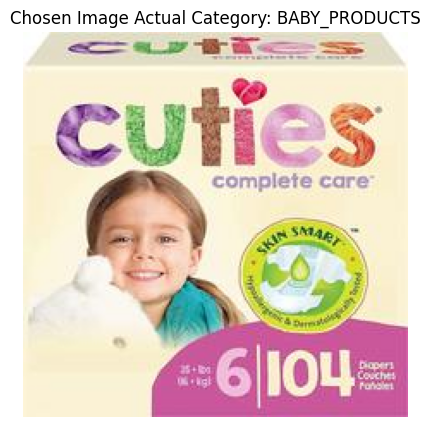

Model Predicts:   
                            Class  Probability
0                   BABY_PRODUCTS          1.0
1              HOME_KITCHEN_TOOLS          0.0
2                   BEAUTY_HEALTH          0.0
3                    PET_SUPPLIES          0.0
4           HOBBY_ARTS_STATIONERY          0.0
5                     ELECTRONICS          0.0
6                         GROCERY          0.0
7  CLOTHING_ACCESSORIES_JEWELLERY          0.0
8                  SPORTS_OUTDOOR          0.0


In [51]:
from tensorflow.keras.preprocessing import image

image_path, image_class = get_random_image(check_dir)
loaded_img, array_image = preprocess_image(image_path)
predictions = model.predict(array_image)
sorted_class_labels, sorted_probabilities = bring_predict_probas(predictions)
df = create_dataframe(sorted_class_labels, sorted_probabilities)
display_image(loaded_img, image_class)

print(f"Model Predicts:   ")
print(df)